Setup
====

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import nltk
import numpy as np
nltk.download('punkt')
%matplotlib inline


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
data_paths = [f'drive/MyDrive/Data/refsa-sample-data/{x}/use_as_train_{x}.csv' for x in ["ERIS", "Isoflavones", "Bacillus"]]
validation_paths =  [f'drive/MyDrive/Data/refsa-sample-data/{x}/use_as_validation_{x}.csv' for x in ["ERIS", "Isoflavones", "Bacillus"]]
preprocessed_dir = 'drive/MyDrive/Data/refsa-sample-data/cleaned/'

In [4]:
df = pd.read_csv(data_paths[2], index_col=0)
df_test = pd.read_csv(validation_paths[2], index_col=0)
print("Class -1")
print(len(df[df['Indicator']==-1]), "out of", len(df))
print(len(df_test[df_test['Indicator']==-1]),"out of" , len(df_test))

print("Class 1")
print(len(df[df['Indicator']==1]), "out of", len(df))
print(len(df_test[df_test['Indicator']==1]),"out of" , len(df_test))

Class -1
2957 out of 3078
743 out of 770
Class 1
121 out of 3078
27 out of 770


In [5]:
#loading preprocessed data to make each section indepenent
def load_preprocessed():
  df_train = pd.read_csv(preprocessed_dir + "cleaned_train_ERIS.csv", index_col=0)
  df_test = pd.read_csv(preprocessed_dir + "cleaned_test_ERIS.csv", index_col=0)
  X_train = df_train.drop("Indicator", axis=1)
  y_train = df_train["Indicator"]

  X_test = df_test.drop("Indicator", axis=1)
  y_test = df_test["Indicator"]
  return X_train, X_test, y_train, y_test

In [6]:
#load data of documents with averaged glove vectors for each documents' abstract
def load_avg_glove():
  df_train = pd.read_csv(preprocessed_dir + "glove_train_ERIS.csv", index_col=0)
  df_test = pd.read_csv(preprocessed_dir + "glove_test_ERIS.csv", index_col=0)
  X_train = df_train.drop("Indicator", axis=1)
  y_train = df_train["Indicator"]

  X_test = df_test.drop("Indicator", axis=1)
  y_test = df_test["Indicator"]
  return X_train, X_test, y_train, y_test

Initial data exploration
====



In [7]:
df = pd.read_csv(data_paths[0], index_col=0)
df_test = pd.read_csv(validation_paths[0], index_col=0)

print(df.shape, df_test.shape)
df.head()

(527, 5) (132, 5)


,X...Author,Title,Abstract,Journal,Indicator
377,"O. Wessel, C. M. Olsen, E. Rimstad and M. K. D...",Piscine orthoreovirus (PRV) replicates in Atla...,Piscine orthoreovirus (PRV) is a reovirus that...,Vet Res,-1
172,"M. C. Hikke, C. Geertsema, V. Wu, S. W. Metz, ...",Alphavirus capsid proteins self-assemble into ...,The mosquito-borne chikungunya virus (CHIKV) c...,Biotechnol J,-1
248,"J. Nacher-Mestre, R. Serrano, E. Beltran, J. P...",Occurrence and potential transfer of mycotoxin...,Plant ingredients and processed animal protein...,Chemosphere,1
525,"B. D. Johnson, S. L. Gilbert, B. Khan, D. L. C...","Cellular responses of eastern oysters, Crassos...",Because of the continued development and produ...,Mar Environ Res,1
614,"L. Zi-qi, M. Qian, S. Feng-qing, W. Ying-wen, ...",Research progress of chitosan and its derivati...,"Recently, the problem of heavy metal pollution...",Food & Machinery,-1


In [8]:
#check for null values
df.isnull().sum()

X...Author    0
Title         0
Abstract      0
Journal       1
Indicator     0
dtype: int64

In [9]:
X = df[["Title", "Abstract"]].copy()
y_train = df["Indicator"]

X_test = df_test[["Title", "Abstract"]]
y_test = df_test["Indicator"]

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

#preprocess train data
vectorizerAb = CountVectorizer()
vectorizerTit = CountVectorizer()

preprocessedAbstract = vectorizerAb.fit_transform(X["Abstract"].values)
abstracts = pd.DataFrame(data=preprocessedAbstract.toarray(), index=X.index, columns = vectorizerAb.get_feature_names())

preprocessedTitle = vectorizerTit.fit_transform(X["Title"].values)
titles = pd.DataFrame(data=preprocessedTitle.toarray(), index=X.index, columns = vectorizerTit.get_feature_names())

x_train = pd.concat([abstracts, titles], axis=1)

preprocessedAbstract = vectorizerAb.transform(X_test["Abstract"].values)
abstracts = pd.DataFrame(data=preprocessedAbstract.toarray(), index=X_test.index, columns = vectorizerAb.get_feature_names())

preprocessedTitle = vectorizerTit.transform(X_test["Title"].values)
titles = pd.DataFrame(data=preprocessedTitle.toarray(), index=X_test.index, columns = vectorizerTit.get_feature_names())

x_test= pd.concat([abstracts, titles], axis=1)
print(x_test.shape, x_train.shape)

(132, 13227) (527, 13227)


In [11]:
# Both train and test datasets are very small so it would be a good idea to first
# check if they come from the same data distribution using Adversial Validation
from scipy import sparse
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

def adversial_validation(train_df, test_df, n_splits=5):
  train_df["__dist"]=np.zeros((train_df.shape[0],))
  test_df["__dist"]=np.ones((test_df.shape[0],))

  merged = pd.concat([train_df, test_df], axis=0)
  features = merged.drop("__dist", axis=1)
  dists = merged["__dist"]

  auc_log = []
  auc_rf = []
  kfold = StratifiedKFold(n_splits=n_splits, shuffle=True)

  for train_idx, test_idx in kfold.split(features, dists):
    x_train, y_train = features.take(train_idx), dists.take(train_idx)
    x_test, y_test = features.take(test_idx), dists.take(test_idx)

    #train sgd
    log = LogisticRegression()
    log.fit(x_train, y_train)
    test_prob = log.predict_proba(x_test)[:,1]
    auc_log.append(roc_auc_score(y_test, test_prob))

    #train random forests
    rf = RandomForestClassifier(n_estimators=100, n_jobs = -1)
    rf.fit(x_train, y_train)
    test_prob = rf.predict_proba(x_test)[:,1]
    auc_rf.append(roc_auc_score(y_test, test_prob))

  print(f'RandomForest: {np.mean(auc_rf)}')
  print(f'Logistic Regression: {np.mean(auc_log)}')

adversial_validation(x_train.copy(), x_test.copy())

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


RandomForest: 0.45690944624906893
Logistic Regression: 0.5099803923074363


AUC score abround 50 % siginifies that test data is drawn from the same distribution as train data. That's good - one worry less

Cleaning the data
===


In [12]:
for abs in df["Abstract"][:4]:
    print(abs + "\n")

Piscine orthoreovirus (PRV) is a reovirus that has predominantly been detected in Atlantic salmon (Salmo salar L.). PRV is associated with heart and skeletal muscle inflammation (HSMI) in farmed Atlantic salmon, and recently erythrocytes were identified as major target cells. The study of PRV replication and pathogenesis of the infection has been impeded by the inability to propagate PRV in vitro. In this study we developed an ex vivo cultivation system for PRV in Atlantic salmon erythrocytes. PRV was successfully passaged to naive erythrocytes using lysates of blood cells from infected salmon. During cultivation a significant increase in viral load was observed by RT-qPCR and flow cytometry, which coincided with the formation of cytoplasmic inclusions. The inclusions resembled viral factories and contained both PRV protein and dsRNA. In addition, the erythrocytes generated an antiviral immune gene activation after PRV infection, with significant up-regulation of IFN-alpha, RIG-I, Mx a

Things to consider when cleaning the data:
- abreviations
- numeric values and citation numbers
- hyphenated words like *mosquito-borne*

There is probably no need to remove contractions due to scientific nature of the data. 


In [13]:
#tokenize and lowercase
from nltk.tokenize import word_tokenize

def tokenize_and_lower(s):
    return [x.lower() for x in word_tokenize(s)]

X["tokenized_title"] = X["Title"].apply(tokenize_and_lower)
X["tokenized_abstract"] = X["Abstract"].apply(tokenize_and_lower)

X_test["tokenized_title"] = X_test["Title"].apply(tokenize_and_lower)
X_test["tokenized_abstract"] = X_test["Abstract"].apply(tokenize_and_lower)

X.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,Title,Abstract,tokenized_title,tokenized_abstract
377,Piscine orthoreovirus (PRV) replicates in Atla...,Piscine orthoreovirus (PRV) is a reovirus that...,"[piscine, orthoreovirus, (, prv, ), replicates...","[piscine, orthoreovirus, (, prv, ), is, a, reo..."
172,Alphavirus capsid proteins self-assemble into ...,The mosquito-borne chikungunya virus (CHIKV) c...,"[alphavirus, capsid, proteins, self-assemble, ...","[the, mosquito-borne, chikungunya, virus, (, c..."
248,Occurrence and potential transfer of mycotoxin...,Plant ingredients and processed animal protein...,"[occurrence, and, potential, transfer, of, myc...","[plant, ingredients, and, processed, animal, p..."
525,"Cellular responses of eastern oysters, Crassos...",Because of the continued development and produ...,"[cellular, responses, of, eastern, oysters, ,,...","[because, of, the, continued, development, and..."
614,Research progress of chitosan and its derivati...,"Recently, the problem of heavy metal pollution...","[research, progress, of, chitosan, and, its, d...","[recently, ,, the, problem, of, heavy, metal, ..."


In [14]:
#remove punctuation and stopwords
import string
from nltk.corpus import stopwords
nltk.download('stopwords')

chars_for_removal = set(list(string.punctuation) + stopwords.words("english"))
print(chars_for_removal)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
{"'", 'were', '}', '=', 'more', 'does', 'there', 'them', 'of', '(', 'can', 'ain', 'as', '?', 'mustn', 'him', '&', 'ourselves', 'up', 'out', 'itself', 'which', '{', '\\', "mustn't", 'or', 'now', 'wouldn', 'aren', "you'll", 's', 'did', 'by', 'was', 'i', 'it', 'had', 're', "needn't", "you're", 'once', 'doing', 'am', '"', "mightn't", "haven't", 'but', '%', 'he', 'between', 'over', 'during', 'mightn', 'hasn', '@', 'you', ',', ']', '|', '<', 'she', 'll', 'didn', 'that', 'whom', 'wasn', "shan't", 'a', 'an', 'until', "should've", 'be', 'o', 'himself', 'only', 'doesn', "didn't", 'and', 'do', 'into', 'all', 'down', 'when', 'theirs', 'don', ')', 'very', "aren't", 'has', '*', 'hadn', 'no', 'hers', 'd', "weren't", 'under', 'will', "that'll", 'herself', 'then', 'through', 'same', 'yourself', ';', '~', 'have', 'should', "isn't", 'won', ':', 'me', 'before', 'having', 'in', 'if', 'with

In [15]:
def filter_words(string_list):
    return [word for word in string_list if word not in chars_for_removal]

X["filtered_title"] = X["tokenized_title"].apply(filter_words)
X["filtered_abstract"] = X["tokenized_abstract"].apply(filter_words)

X_test["filtered_title"] = X_test["tokenized_title"].apply(filter_words)
X_test["filtered_abstract"] = X_test["tokenized_abstract"].apply(filter_words)
X.head()

,Title,Abstract,tokenized_title,tokenized_abstract,filtered_title,filtered_abstract
377,Piscine orthoreovirus (PRV) replicates in Atla...,Piscine orthoreovirus (PRV) is a reovirus that...,"[piscine, orthoreovirus, (, prv, ), replicates...","[piscine, orthoreovirus, (, prv, ), is, a, reo...","[piscine, orthoreovirus, prv, replicates, atla...","[piscine, orthoreovirus, prv, reovirus, predom..."
172,Alphavirus capsid proteins self-assemble into ...,The mosquito-borne chikungunya virus (CHIKV) c...,"[alphavirus, capsid, proteins, self-assemble, ...","[the, mosquito-borne, chikungunya, virus, (, c...","[alphavirus, capsid, proteins, self-assemble, ...","[mosquito-borne, chikungunya, virus, chikv, ca..."
248,Occurrence and potential transfer of mycotoxin...,Plant ingredients and processed animal protein...,"[occurrence, and, potential, transfer, of, myc...","[plant, ingredients, and, processed, animal, p...","[occurrence, potential, transfer, mycotoxins, ...","[plant, ingredients, processed, animal, protei..."
525,"Cellular responses of eastern oysters, Crassos...",Because of the continued development and produ...,"[cellular, responses, of, eastern, oysters, ,,...","[because, of, the, continued, development, and...","[cellular, responses, eastern, oysters, crasso...","[continued, development, production, variety, ..."
614,Research progress of chitosan and its derivati...,"Recently, the problem of heavy metal pollution...","[research, progress, of, chitosan, and, its, d...","[recently, ,, the, problem, of, heavy, metal, ...","[research, progress, chitosan, derivatives, re...","[recently, problem, heavy, metal, pollution, a..."


Im not sure whether stemming the data would be a good choice - will domain-specific words get well lematized?



In [16]:
#adding pos tags for lemmatization with wordnet
from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
X["pos_title"] = X["filtered_title"].apply(nltk.tag.pos_tag)
X["pos_abstract"] = X["filtered_abstract"].apply(nltk.tag.pos_tag)

X_test["pos_title"] = X_test["filtered_title"].apply(nltk.tag.pos_tag)
X_test["pos_abstract"] = X_test["filtered_abstract"].apply(nltk.tag.pos_tag)

def map_to_wordnet_pos(tuple_list):
    return [(word, get_wnet_tag(tag)) for (word, tag) in tuple_list]
 
def get_wnet_tag(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    if tag.startswith('V'):
        return wordnet.VERB
    if tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
X_test["wntag_title"] = X_test["pos_title"].apply(map_to_wordnet_pos)
X_test["wntag_abstract"] = X_test["pos_abstract"].apply(map_to_wordnet_pos)  
X["wntag_title"] = X["pos_title"].apply(map_to_wordnet_pos)
X["wntag_abstract"] = X["pos_abstract"].apply(map_to_wordnet_pos)   

X.head()


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


,Title,Abstract,tokenized_title,tokenized_abstract,filtered_title,filtered_abstract,pos_title,pos_abstract,wntag_title,wntag_abstract
377,Piscine orthoreovirus (PRV) replicates in Atla...,Piscine orthoreovirus (PRV) is a reovirus that...,"[piscine, orthoreovirus, (, prv, ), replicates...","[piscine, orthoreovirus, (, prv, ), is, a, reo...","[piscine, orthoreovirus, prv, replicates, atla...","[piscine, orthoreovirus, prv, reovirus, predom...","[(piscine, NN), (orthoreovirus, NN), (prv, NN)...","[(piscine, NN), (orthoreovirus, NN), (prv, NN)...","[(piscine, n), (orthoreovirus, n), (prv, n), (...","[(piscine, n), (orthoreovirus, n), (prv, n), (..."
172,Alphavirus capsid proteins self-assemble into ...,The mosquito-borne chikungunya virus (CHIKV) c...,"[alphavirus, capsid, proteins, self-assemble, ...","[the, mosquito-borne, chikungunya, virus, (, c...","[alphavirus, capsid, proteins, self-assemble, ...","[mosquito-borne, chikungunya, virus, chikv, ca...","[(alphavirus, NN), (capsid, NN), (proteins, VB...","[(mosquito-borne, JJ), (chikungunya, NN), (vir...","[(alphavirus, n), (capsid, n), (proteins, v), ...","[(mosquito-borne, a), (chikungunya, n), (virus..."
248,Occurrence and potential transfer of mycotoxin...,Plant ingredients and processed animal protein...,"[occurrence, and, potential, transfer, of, myc...","[plant, ingredients, and, processed, animal, p...","[occurrence, potential, transfer, mycotoxins, ...","[plant, ingredients, processed, animal, protei...","[(occurrence, NN), (potential, NN), (transfer,...","[(plant, NN), (ingredients, NNS), (processed, ...","[(occurrence, n), (potential, n), (transfer, n...","[(plant, n), (ingredients, n), (processed, v),..."
525,"Cellular responses of eastern oysters, Crassos...",Because of the continued development and produ...,"[cellular, responses, of, eastern, oysters, ,,...","[because, of, the, continued, development, and...","[cellular, responses, eastern, oysters, crasso...","[continued, development, production, variety, ...","[(cellular, JJ), (responses, NNS), (eastern, J...","[(continued, JJ), (development, NN), (producti...","[(cellular, a), (responses, n), (eastern, a), ...","[(continued, a), (development, n), (production..."
614,Research progress of chitosan and its derivati...,"Recently, the problem of heavy metal pollution...","[research, progress, of, chitosan, and, its, d...","[recently, ,, the, problem, of, heavy, metal, ...","[research, progress, chitosan, derivatives, re...","[recently, problem, heavy, metal, pollution, a...","[(research, NN), (progress, NN), (chitosan, JJ...","[(recently, RB), (problem, NN), (heavy, JJ), (...","[(research, n), (progress, n), (chitosan, a), ...","[(recently, r), (problem, n), (heavy, a), (met..."


In [17]:
#lemmatize with wordnet
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()

def lemmatize(tuple_list):
    return [lemmatizer.lemmatize(word, tag) for (word, tag) in tuple_list]

X["lem_title"] = X["wntag_title"].apply(lemmatize)
X["lem_abstract"] = X["wntag_abstract"].apply(lemmatize)

X_test["lem_title"] = X_test["wntag_title"].apply(lemmatize)
X_test["lem_abstract"] = X_test["wntag_abstract"].apply(lemmatize)

cleaned_text = pd.DataFrame(data=X[["lem_title", "lem_abstract"]], index = X.index)
cleaned_text = cleaned_text.rename(columns={"lem_title":"title", "lem_abstract": "abstract"})

cleaned_text_test = pd.DataFrame(data=X_test[["lem_title", "lem_abstract"]], index = X_test.index)
cleaned_text_test = cleaned_text_test.rename(columns={"lem_title":"title", "lem_abstract": "abstract"})

cleaned_text.head()

,title,abstract
377,"[piscine, orthoreovirus, prv, replicate, atlan...","[piscine, orthoreovirus, prv, reovirus, predom..."
172,"[alphavirus, capsid, proteins, self-assemble, ...","[mosquito-borne, chikungunya, virus, chikv, ca..."
248,"[occurrence, potential, transfer, mycotoxins, ...","[plant, ingredient, process, animal, protein, ..."
525,"[cellular, response, eastern, oyster, crassost...","[continued, development, production, variety, ..."
614,"[research, progress, chitosan, derivative, rem...","[recently, problem, heavy, metal, pollution, a..."


In [18]:
# connect lists back into strings
def list_to_string (str_list):
  return " ".join(str_list)
cleaned_text["abs_str"] = cleaned_text["abstract"].apply(list_to_string)
cleaned_text["tit_str"] = cleaned_text["title"].apply(list_to_string)

cleaned_text_test["abs_str"] = cleaned_text_test["abstract"].apply(list_to_string)
cleaned_text_test["tit_str"] = cleaned_text_test["title"].apply(list_to_string)

cleaned_text = cleaned_text.drop(labels = ["abstract", "title"], axis=1)
cleaned_text_test = cleaned_text_test.drop(labels = ["abstract", "title"], axis=1)

print(cleaned_text.head())


                                               abs_str                                            tit_str
377  piscine orthoreovirus prv reovirus predominant...  piscine orthoreovirus prv replicate atlantic s...
172  mosquito-borne chikungunya virus chikv cause a...  alphavirus capsid proteins self-assemble core-...
248  plant ingredient process animal protein pap su...  occurrence potential transfer mycotoxins gilth...
525  continued development production variety nanom...  cellular response eastern oyster crassostrea v...
614  recently problem heavy metal pollution attract...  research progress chitosan derivative removal ...


In [19]:
clean_train = pd.concat([cleaned_text, y_train], axis=1)
clean_train.to_csv(preprocessed_dir + "cleaned_train_ERIS.csv")
clean_test =pd.concat([cleaned_text_test, y_test], axis=1)
clean_test.to_csv(preprocessed_dir +"cleaned_test_ERIS.csv")
print(clean_train.shape, clean_test.shape)

(527, 3) (132, 3)


TODO
----
- what to do with numerical values? and with words that combine numbers and letters

Exploratory Data Analysis
===

In [20]:
#loading preprocessed data to make each section indepenent
df_train = pd.read_csv(preprocessed_dir + "cleaned_train_ERIS.csv", index_col=0)
df_test = pd.read_csv(preprocessed_dir + "cleaned_test_ERIS.csv", index_col=0)

print(df_test.shape, df_train.shape)

(132, 3) (527, 3)


In [21]:
X_train = df_train.drop("Indicator", axis=1)
y_train = df_train["Indicator"]

X_test = df_test.drop("Indicator", axis=1)
y_test = df_test["Indicator"]
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
X_train.head()

(527, 2) (132, 2) (527,) (132,)


,abs_str,tit_str
377,piscine orthoreovirus prv reovirus predominant...,piscine orthoreovirus prv replicate atlantic s...
172,mosquito-borne chikungunya virus chikv cause a...,alphavirus capsid proteins self-assemble core-...
248,plant ingredient process animal protein pap su...,occurrence potential transfer mycotoxins gilth...
525,continued development production variety nanom...,cellular response eastern oyster crassostrea v...
614,recently problem heavy metal pollution attract...,research progress chitosan derivative removal ...


In [22]:
X_rel = X_train[y_train==1]
X_irrel = X_train[y_train==-1]

abs_words_rel = []
for abs_word in X_rel["abs_str"]:
  abs_words_rel += abs_word.split(" ")

abs_words_irrel = []
for abs_word in X_irrel["tit_str"]:
  abs_words_irrel += abs_word.split(" ")

print(len(abs_words_rel), abs_words_rel)
print(len(abs_words_irrel), abs_words_irrel)

12401 ['plant', 'ingredient', 'process', 'animal', 'protein', 'pap', 'suitable', 'alternative', 'feedstuffs', 'fish', 'feed', 'aquaculture', 'practice', 'although', 'use', 'introduce', 'contaminant', 'previously', 'associate', 'marine', 'salmon', 'gilthead', 'sea', 'bream', 'farming', 'mycotoxin', 'well', 'know', 'natural', 'contaminant', 'plant', 'fee', 'material', 'although', 'also', 'could', 'present', 'pap', 'fungi', 'growth', 'storage', 'present', 'study', 'survey', 'commercially', 'available', 'plant', 'ingredient', '19', 'pap', '19', 'wide', 'range', 'mycotoxin', '18', 'accord', 'eu', 'regulation', 'pap', 'show', 'minor', 'level', 'ochratoxin', 'fumonisin', 'b1', 'mycotoxin', 'carry-over', 'feed', 'fillet', 'farm', 'atlantic', 'salmon', 'gilthead', 'sea', 'bream', 'two', 'main', 'specie', 'european', 'aquaculture', 'perform', 'plant', 'ingredient', 'base', 'diet', 'deoxynivalenol', 'prevalent', 'mycotoxin', 'wheat', 'wheat', 'gluten', 'corn', 'gluten', 'cereal', 'level', 'range'

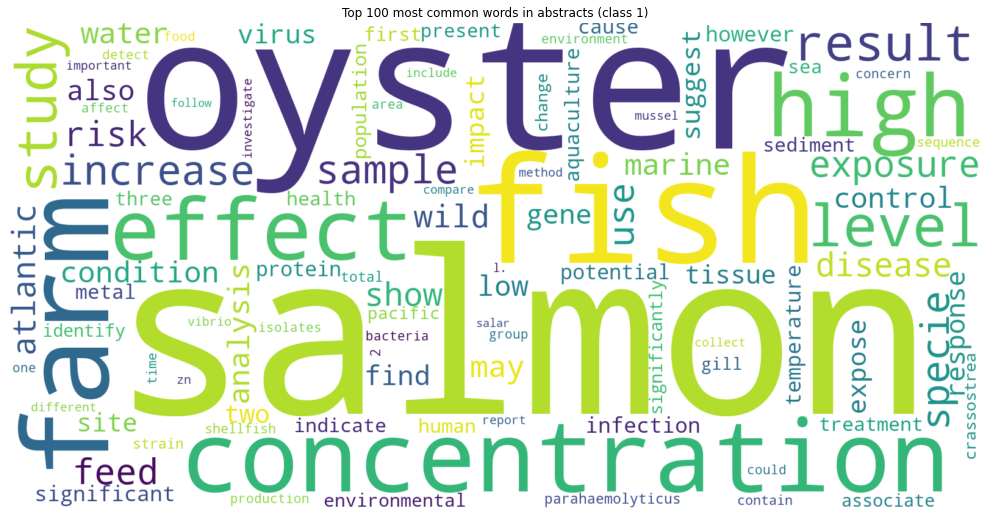

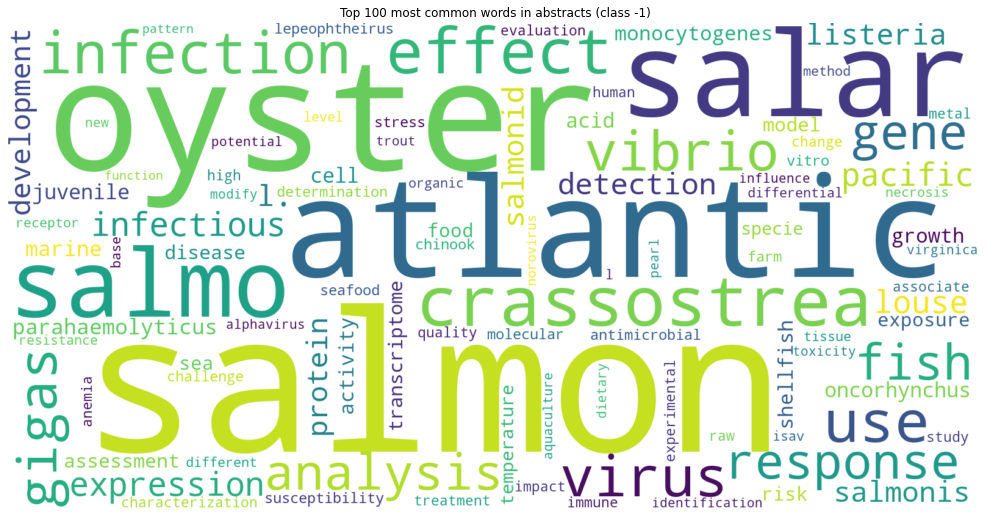

In [25]:
from nltk.probability import FreqDist
from wordcloud import WordCloud
def to_dict(tuple_list):
  result = dict()
  for key, value in tuple_list:
    result[key]=value
  return result


most_rel = to_dict(FreqDist(abs_words_rel).most_common(100))
cloud_a = WordCloud(width=1600, height= 800, background_color='white').fit_words(most_rel)
fig = plt.figure(figsize=(20,7), facecolor='white')
plt.imshow(cloud_a, interpolation='bilinear')
plt.axis('off')
plt.title('Top 100 most common words in abstracts (class 1)')
plt.tight_layout(pad=0)
plt.show()
print("\n\n")
most_irrel = to_dict(FreqDist(abs_words_irrel).most_common(100))
cloud_a = WordCloud(width=1600, height= 800, background_color='white').fit_words(most_irrel)
fig = plt.figure(figsize=(20,7), facecolor='white')
plt.imshow(cloud_a, interpolation='bilinear')
plt.axis('off')
plt.title('Top 100 most common words in abstracts (class -1)')
plt.tight_layout(pad=0)
plt.show()

A first glance look at most popular words in both classes does not seem to indicate much difference between them - they both talk about oysters and fish, research and its results

In [26]:
#dimensionality reduction for visualisation purposes
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=50, n_iter=10)
reduced_train = svd.fit_transform(x_train)
reduced_train

array([[20.19164151, -0.16024778,  4.39090824, ...,  0.45540724,
         0.0603986 , -0.26644625],
       [15.89085815,  1.07255444,  2.98773146, ..., -0.34298282,
         0.07111464, -0.51687867],
       [20.19161906, -3.7741743 ,  1.92123297, ..., -2.52895835,
         0.52149852, -0.90832316],
       ...,
       [17.07837552,  5.48761444,  3.49159825, ..., -0.67657266,
         1.0361427 , -0.11196421],
       [21.17810992,  1.52208616,  4.33609314, ...,  1.50326208,
        -0.48894344,  0.25198714],
       [18.7886535 ,  5.72190124,  4.51338665, ..., -0.98555718,
        -0.73198915, -0.7432003 ]])

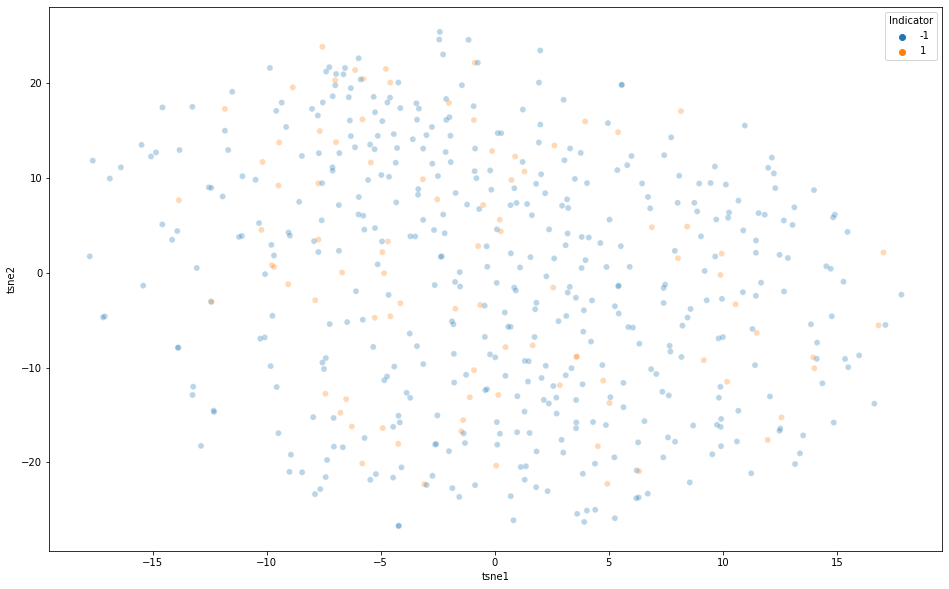

In [27]:
from sklearn.manifold import TSNE
X_embedded = pd.DataFrame(TSNE(n_components=2).fit_transform(reduced_train), index = x_train.index, columns=["tsne1", "tsne2"])

plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne1", y="tsne2", hue = y_train, data = X_embedded, legend="full", alpha=0.3, palette = sns.color_palette(n_colors=2) )


Both of the classes seem very mixed with bow encoding so it will most likely be necessary to explore different embedding options

Classification
===


In [28]:
X_train, X_test, y_train, y_test = load_preprocessed()
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(527, 2) (132, 2) (527,) (132,)


In [29]:
#baseline classifier - always return majority class
class BaselineClassifier:
    def __init__(self):
        self.majority_class = np.NaN
        
    def fit(self, x, y):
        self.majority_class = y.value_counts()[:1].index.to_list()[0]
        return
    def predict(self, x):
        return pd.Series(np.ones((x.shape[0],)) * self.majority_class, index = x.index)
    
    def score(self, x, y):
        p = self.predict(x)
        comp = y==p
        return len(comp[comp==True])/len(comp)
        
        
baseline = BaselineClassifier()
baseline.fit(X_test,y_train)
score = baseline.score(X_test, y_test)
print(f'Baseline classifier\'s accuracy (always returns majority class): {score}')

Baseline classifier's accuracy (always returns majority class): 0.8484848484848485


**Baseline classifier** achieves expected accuracy -  84,84% which corresponds to how many of training examples are of majority class. 

In [30]:
from sklearn.feature_extraction.text import CountVectorizer

#preprocess train data
vectorizerAb = CountVectorizer()
vectorizerTit = CountVectorizer()

preprocessedAbstract = vectorizerAb.fit_transform(X_train["abs_str"].values)
abstracts = pd.DataFrame(data=preprocessedAbstract.toarray(), index=cleaned_text.index, columns = vectorizerAb.get_feature_names())

preprocessedTitle = vectorizerTit.fit_transform(X_train["tit_str"].values)
titles = pd.DataFrame(data=preprocessedTitle.toarray(), index=cleaned_text.index, columns = vectorizerTit.get_feature_names())

x_train = pd.concat([abstracts, titles], axis=1)
print(x_train.shape)
print(x_train.head())

(527, 11763)
     00  000  0000  0001  0003  ...  yersiniosis  zealand  zinc  zn  zooplankton
377   0    0     0     0     0  ...            0        0     0   0            0
172   0    0     0     0     0  ...            0        0     0   0            0
248   0    0     0     0     0  ...            0        0     0   0            0
525   0    0     0     0     0  ...            0        0     0   0            0
614   0    0     0     0     0  ...            0        0     0   0            0

[5 rows x 11763 columns]


In [31]:
#preprocess test data
abstracts_test = vectorizerAb.transform(cleaned_text_test["abs_str"].values)
titles_test = vectorizerTit.transform(cleaned_text_test["tit_str"].values)

prep_ab = pd.DataFrame(data=abstracts_test.toarray(), index = cleaned_text_test.index, columns = vectorizerAb.get_feature_names())
prep_tit = pd.DataFrame(data=titles_test.toarray(), index=cleaned_text_test.index, columns = vectorizerTit.get_feature_names())

x_test = pd.concat([prep_ab, prep_tit],axis=1)
print(x_test.shape)
x_test.head()

(132, 11763)


,00,000,0000,0001,0003,0006,000smolts,001,002,0025,0026,003,004,005,006,007,01,0135,0138,014,018,02,022,023,024,026,0296,03,035,0366,04,0421,045,0467,047,04pmol,05,050mugl,05mugl,06,...,vp2,vp3,vp4,vp5,vulnificus,wadden,walbaum,warm,washington,waste,wastewater,water,wax,week,weight,well,western,whey,white,wild,willamette,willapa,willingness,wistar,within,woman,wood,worker,world,worldwide,wrasse,xylose,year,yeast,yersinia,yersiniosis,zealand,zinc,zn,zooplankton
374,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
304,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
247,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
125,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [32]:
# save vectorized test and train data
test_bow = pd.concat([x_test, y_test], axis=1)
train_bow = pd.concat([x_train, y_train], axis=1)
print(test_bow.shape, train_bow.shape)
test_bow.to_csv(preprocessed_dir + "bow_test_ERIS.csv")
train_bow.to_csv(preprocessed_dir + "bow_train_ERIS.csv")

(132, 11764) (527, 11764)


In [33]:
from sklearn.linear_model import LogisticRegression
scores = {}
y = y_train
logistic = LogisticRegression()
logistic.fit(x_train, y)
test_score_logistic = logistic.score(x_test, y_test)
train_score_logistic = logistic.score(x_train, y_train)
print(f'Accuracy for Logistic Regression Classifier with CountVectorization\n test: {test_score_logistic}\t\t train: {train_score_logistic}')

Accuracy for Logistic Regression Classifier with CountVectorization
 test: 0.7878787878787878		 train: 1.0


In [34]:
from sklearn.svm import LinearSVC
scores = {}
y = y_train
linearSVC = LinearSVC()
linearSVC.fit(x_train, y)
test_score_linearSVC = linearSVC.score(x_test, y_test)
train_score_linearSVC = linearSVC.score(x_train, y_train)
print(f'Accuracy for Linear SVC with CountVectorization\n test: {test_score_linearSVC}\t train: {train_score_linearSVC}')

Accuracy for Linear SVC with CountVectorization
 test: 0.7954545454545454	 train: 1.0


Improving classification
====
Utilities
---


In [35]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, recall_score
def calculate_metrics (X_test, y_test, model, verbose=False, confusion = False):
  y_pred = model.predict(X_test)
  acc = accuracy_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  re = recall_score(y_test, y_pred)
  if confusion:
    cm = confusion_matrix(y_test, y_pred)

    plt.title('Confusion Matrix')
    sns.set(font_scale=1.0) #for label size
    sns.heatmap(cm, annot = True, fmt = 'd', xticklabels = ['-1', '1'], yticklabels = ['-1', '1'], annot_kws={"size": 14}, cmap = 'Blues')

    plt.xlabel('Truth')
    plt.ylabel('Prediction')
    plt.show()
  if verbose:
    print(f'Accuracy: {acc}\tF1 score: {f1}\tRecall: {re}')
  return (acc, f1, re)

Bag of Words model
---
For comparison only

In [36]:
df_test = pd.read_csv(preprocessed_dir + "bow_test_ERIS.csv")
df_train = pd.read_csv(preprocessed_dir + "bow_train_ERIS.csv")
x_train_bow = df_train.drop("Indicator", axis=1)
y_train_bow = df_train["Indicator"]

x_test_bow = df_test.drop("Indicator", axis=1)
y_test_bow = df_test["Indicator"]
print(x_train_bow.shape, x_test_bow.shape, y_train_bow.shape, y_test_bow.shape)

(527, 11764) (132, 11764) (527,) (132,)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Scores for LogisticRegression with BOW model


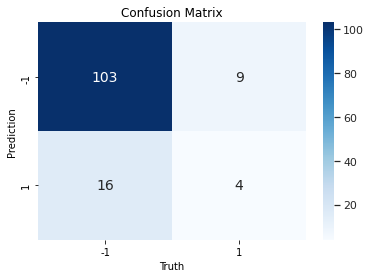

Accuracy: 0.8106060606060606	F1 score: 0.24242424242424246	Recall: 0.2


In [37]:
from sklearn.linear_model import LogisticRegression
logistic = LogisticRegression()
logistic.fit(x_train_bow, y_train_bow)
print("Scores for LogisticRegression with BOW model")
log_bow = calculate_metrics(x_test_bow, y_test_bow, logistic, True, True)

TF-IDF vectorization
----


In [38]:
X_train, X_test, y_train, y_test = load_preprocessed()
X_train.head()

,abs_str,tit_str
377,piscine orthoreovirus prv reovirus predominant...,piscine orthoreovirus prv replicate atlantic s...
172,mosquito-borne chikungunya virus chikv cause a...,alphavirus capsid proteins self-assemble core-...
248,plant ingredient process animal protein pap su...,occurrence potential transfer mycotoxins gilth...
525,continued development production variety nanom...,cellular response eastern oyster crassostrea v...
614,recently problem heavy metal pollution attract...,research progress chitosan derivative removal ...


In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer
#x_train = x_train["abs_str"]
document_list = X_train["abs_str"].tolist()
test_docs = X_test["abs_str"].tolist()


tfidf = TfidfVectorizer()
x_train_tfidf = pd.DataFrame(tfidf.fit_transform(document_list).toarray(), 
                             index = X_train.index, columns = tfidf.get_feature_names())
x_test_tfidf =  pd.DataFrame(tfidf.transform(test_docs).toarray(), 
                             index = X_test.index, columns = tfidf.get_feature_names())
print(x_train_tfidf.shape, x_test_tfidf.shape)

(527, 9455) (132, 9455)


Scores for LogisticRegression with tfidf model


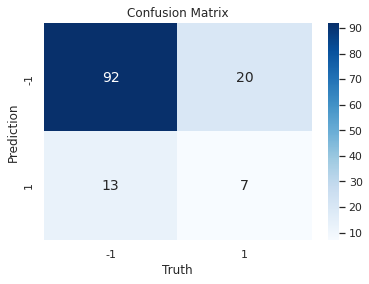

Accuracy: 0.75	F1 score: 0.29787234042553196	Recall: 0.35


In [40]:
from sklearn.linear_model import LogisticRegression
logistic = LogisticRegression(class_weight='balanced')
logistic.fit(x_train_tfidf, y_train)
print("Scores for LogisticRegression with tfidf model")
log_tfidf = calculate_metrics(x_test_tfidf, y_test, logistic, True, True)

Word embeddings
----

In [41]:
X_train, X_test, y_train, y_test = load_preprocessed()
X_train.head()

,abs_str,tit_str
377,piscine orthoreovirus prv reovirus predominant...,piscine orthoreovirus prv replicate atlantic s...
172,mosquito-borne chikungunya virus chikv cause a...,alphavirus capsid proteins self-assemble core-...
248,plant ingredient process animal protein pap su...,occurrence potential transfer mycotoxins gilth...
525,continued development production variety nanom...,cellular response eastern oyster crassostrea v...
614,recently problem heavy metal pollution attract...,research progress chitosan derivative removal ...


In [42]:
import io

def load_glove():
  glove_dir = "drive/MyDrive/Data/embeddings/glove.6B/glove.6B.100d.txt"
  embeddings_idx = {}
  with io.open(glove_dir) as glove_f:
    for line in glove_f:
      values = line.split()
      word = values[0]
      vector = np.asarray(values[1:],dtype='float32')
      embeddings_idx[word]=vector
  return embeddings_idx

glove_dict = load_glove()


In [43]:
def avg_glove(word_list):
  vectors =[]
  for word in word_list:
    if word in glove_dict.keys():
      vectors.append(glove_dict[word])
  return np.array(vectors).mean(axis=0)

In [44]:
embed_list_train = [avg_glove(row["abs_str"]) for idx, row in X_train.iterrows()]
embeddings_train = pd.DataFrame(embed_list_train, index = X_train.index)

embed_list_test = [avg_glove(row["abs_str"]) for idx, row in X_test.iterrows()]
embeddings_test = pd.DataFrame(embed_list_test, index = X_test.index)

In [45]:
glove_train = pd.concat([embeddings_train, y_train], axis=1)
glove_test = pd.concat([embeddings_test, y_test], axis=1)

glove_test.to_csv(preprocessed_dir + "glove_test_ERIS.csv")
glove_train.to_csv(preprocessed_dir + "glove_train_ERIS.csv")


In [46]:
embeddings_train, embeddings_test, y_train, y_test = load_avg_glove()

Scores for LogisticRegression with word vectors model


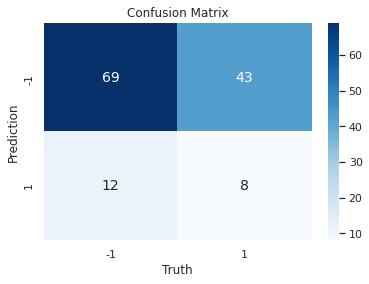

Accuracy: 0.5833333333333334	F1 score: 0.22535211267605632	Recall: 0.4


In [47]:
from sklearn.linear_model import LogisticRegression
logistic = LogisticRegression(class_weight='balanced')
logistic.fit(embeddings_train, y_train)
print("Scores for LogisticRegression with word vectors model")
log_tfidf = calculate_metrics(embeddings_test, y_test, logistic, True, True)

Scores for LogisticRegression with word vectors model


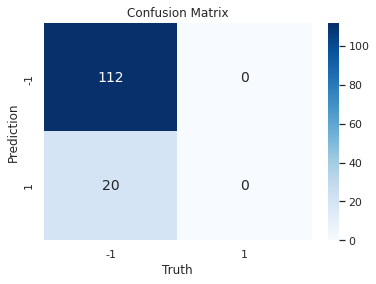

Accuracy: 0.8484848484848485	F1 score: 0.0	Recall: 0.0


In [49]:

logistic = LogisticRegression()
logistic.fit(embeddings_train, y_train)
print("Scores for LogisticRegression with word vectors model")
log_tfidf = calculate_metrics(embeddings_test, y_test, logistic, True, True)